<a href="https://colab.research.google.com/github/Migol123/K-IMU/blob/main/k-IMU.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%pip install tensorboard
%pip install stable-baselines3
%pip install gymnasium
%pip install shimmy
%pip install torch
%pip install stable-baselines3 gym

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import networkx as nx
from math import sqrt

In [4]:
def generador_data(fac, dem, deman_max):
    ancho = 2500
    cor_dem = [(random.randint(1, ancho), random.randint(1, ancho)) for _ in range(dem)]
    dem_p = [random.randint(1, deman_max) for _ in range(dem)]  # Tamaño de puntos escalado para visualización

    cor_fac = [(random.randint(1, ancho), random.randint(1, ancho)) for _ in range(fac)]

    # Crear el grafo
    G = nx.Graph()

    # Añadir nodos de demanda y facilidad al grafo
    for i, coord in enumerate(cor_dem):
        G.add_node(f"D{i}", pos=coord, demand=dem_p[i], color='red', size=dem_p[i])

    for j, coord in enumerate(cor_fac):
        G.add_node(f"F{j}", pos=coord, color='blue', size=100)  # Tamaño fijo para facilidades

    # Conectar nodos si cumplen una condición específica (e.g., todos conectados)
    cover=[]
    for i, c_dem in enumerate(cor_dem):
        for j, c_fac in enumerate(cor_fac):
            # Conectar si la distancia es menor a un umbral, ajustar según necesidad
            if sqrt((c_dem[0] - c_fac[0]) ** 2 + (c_dem[1] - c_fac[1]) ** 2) < 500:
                cover.append(1)
                G.add_edge(f"D{i}", f"F{j}")
            else:
                cover.append(0)

    cover=m_cover=pd.DataFrame(np.array(cover).reshape(fac,dem))
    # Establecer el tamaño de la figura (ancho x alto en pulgadas)
    plt.figure(figsize=(15, 15))  # Ajuste del tamaño de la figura a 15x15 pulgadas
    pos = nx.get_node_attributes(G, 'pos')
    colors = [G.nodes[node]['color'] for node in G.nodes]
    sizes = [G.nodes[node]['size'] for node in G.nodes]

    nx.draw(G, pos, node_color=colors, node_size=sizes, with_labels=False, edge_color='gray', alpha=0.6)
    plt.title('Red de Puntos de Demanda y Facilidades')
    plt.show()
    return dem_p,cover


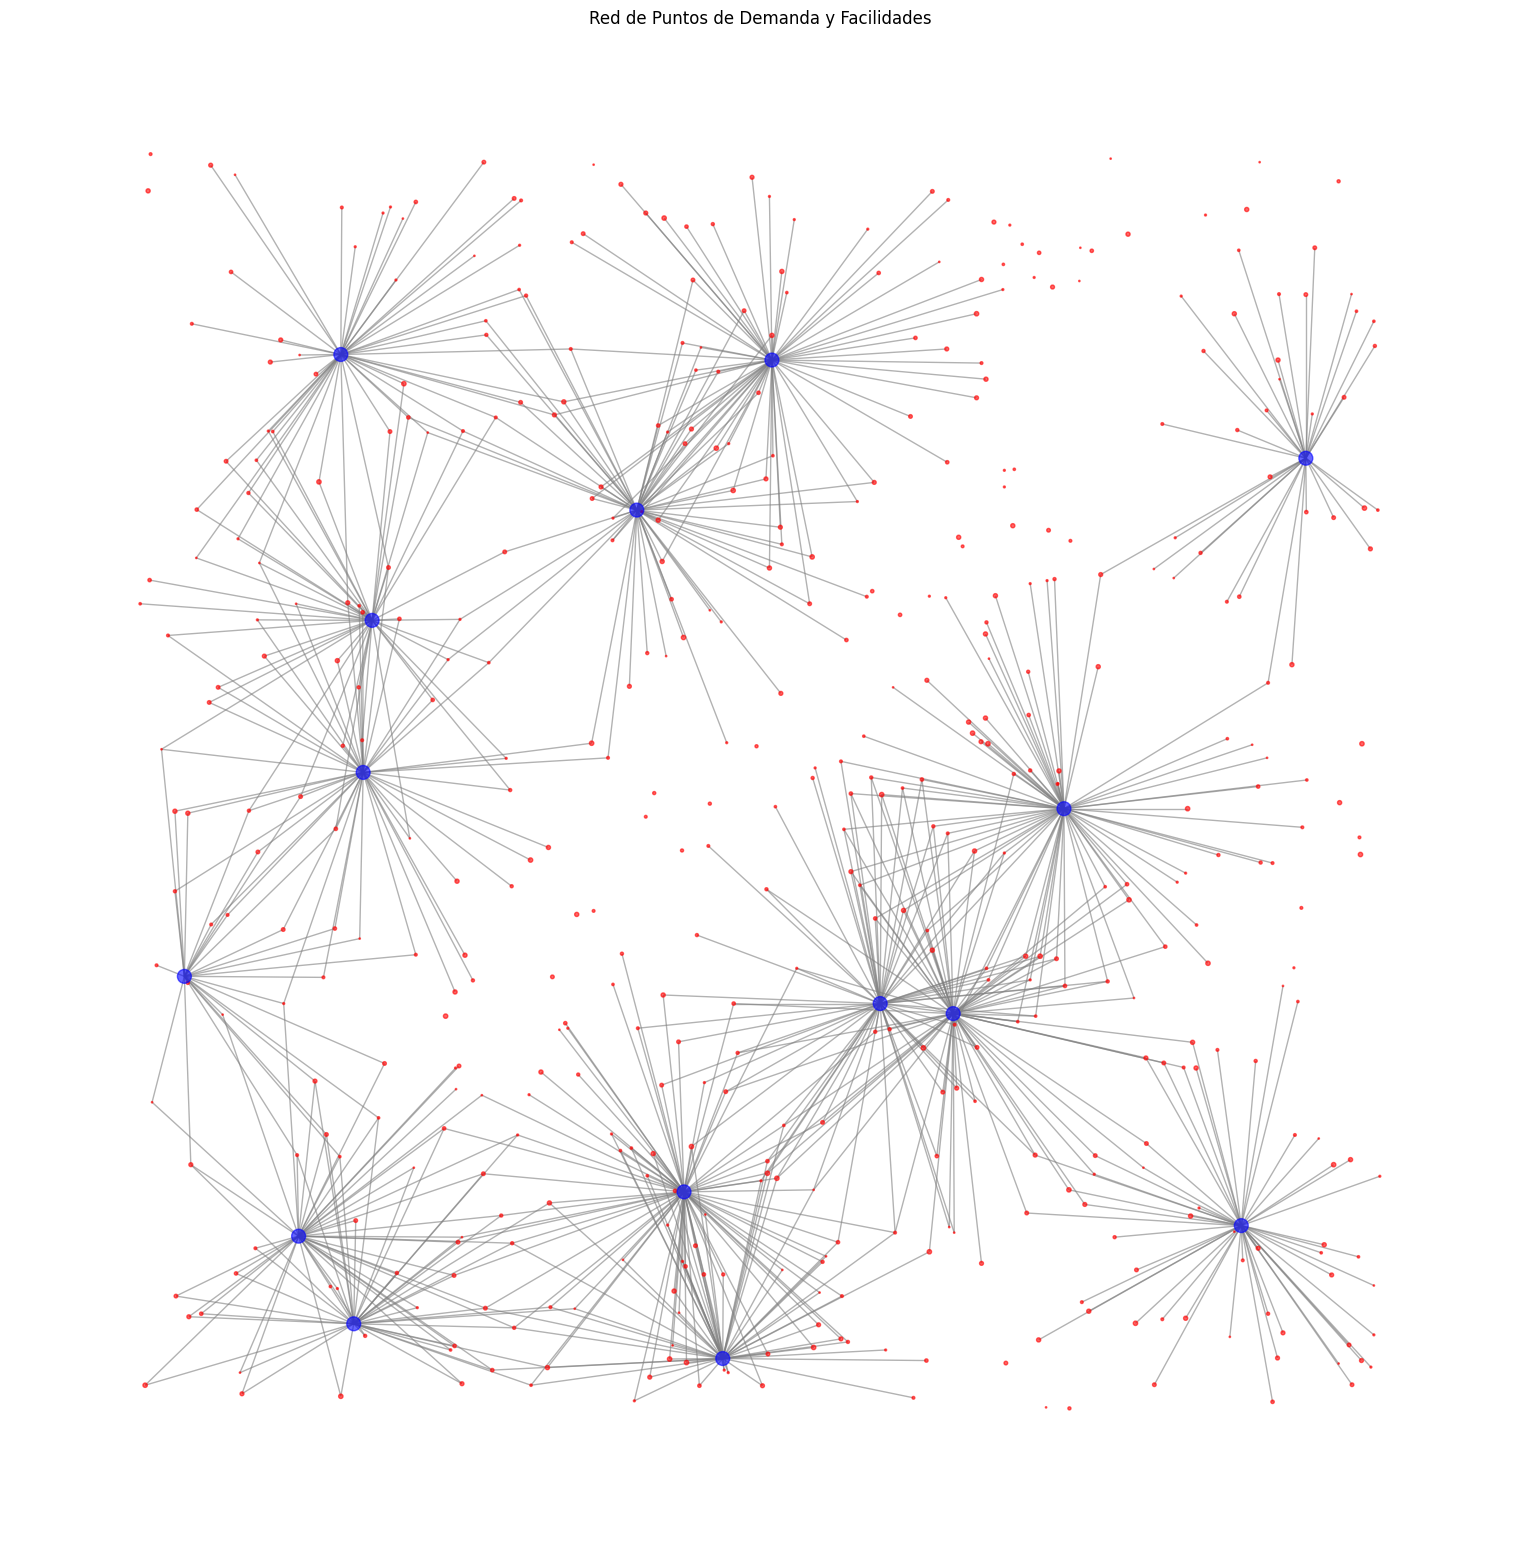

2599


In [43]:
fac=15
demp=500
deman_max=10
m_demp,m_cover=generador_data(fac, demp, deman_max)
print(np.array(m_demp).sum())

In [44]:
fac
demp
deman_max
m_demp
m_cover
num_days=10
max_installations_per_facility=5
print()

In [20]:
from stable_baselines3.common.callbacks import BaseCallback

class CostLoggingCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(CostLoggingCallback, self).__init__(verbose)

    def _on_step(self):
        # Asegúrate de que 'infos' es parte de las variables locales actualizadas en el callback
        infos = self.locals['infos'] if 'infos' in self.locals else None
        # Extraer el costo total si está disponible y registrar en el logger
        if infos and any('total_cost' in info for info in infos):
            # Tomar el primer 'total_cost' encontrado
            for info in infos:
                if 'total_cost' in info:
                    total_cost = info['total_cost']
                    break
            self.logger.record('total_cost', total_cost)
        return True

class TrainingProgressCallback(BaseCallback):
    def __init__(self, verbose=0):
        super(TrainingProgressCallback, self).__init__(verbose)
        self.n_steps = 0

    def _on_step(self) -> bool:
        self.n_steps += 1
        if self.n_steps % 100 == 0:  # Imprime cada 100 steps
            print(f"Step number: {self.n_steps}")
        return True

In [ ]:
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import EvalCallback
import numpy as np
import os

# Definir las matrices de cobertura y demanda
num_demand_points = demp
num_facilities = fac
coverage_matrix = m_cover
demand_matrix = m_demp
num_days=5

# Crear el entorno
env = HumanitarianFacilityLocationEnv(
    num_demand_points=num_demand_points,
    num_facilities=num_facilities,
    num_days=10,
    coverage_matrix=coverage_matrix,
    demand_matrix=demand_matrix,
    max_installations_per_facility=5
)

# Envolver el entorno en DummyVecEnv y Monitor
env = DummyVecEnv([lambda: Monitor(env)])

# Configurar el registro para TensorBoard
log_dir = "./ppo_humanitarian_facility_location_logs/"
os.makedirs(log_dir, exist_ok=True)

# Crear el modelo PPO con soporte para TensorBoard
model = PPO("MlpPolicy", env, verbose=1, tensorboard_log=log_dir)

# Configurar los callbacks
eval_callback = EvalCallback(env, best_model_save_path=log_dir,
                             log_path=log_dir, eval_freq=100,
                             deterministic=True, render=False)
progress_callback = TrainingProgressCallback(verbose=1)

# Entrenar el modelo con los callbacks
cost_callback = CostLoggingCallback()

model.learn(total_timesteps=10000, callback=[eval_callback, progress_callback, cost_callback])


# Guardar el modelo entrenado
model.save("ppo_humanitarian_facility_location")


In [ ]:
# Iniciar TensorBoard
%load_ext tensorboard
%tensorboard --logdir ./ppo_humanitarian_facility_location_logs/

Episodio 1000 - Costo Total: -1749211500.0
Episodio 1000 - Recompensa: 363223000.0
Acción elegida: (4, 0)
Episodio 2000 - Costo Total: -2610635500.0
Episodio 2000 - Recompensa: 587572500.0
Acción elegida: (4, 0)
Episodio 3000 - Costo Total: -1790817000.0
Episodio 3000 - Recompensa: 618638000.0
Acción elegida: (5, 1)
Episodio 4000 - Costo Total: -1500281000.0
Episodio 4000 - Recompensa: 711561500.0
Acción elegida: (0, 1)
Episodio 5000 - Costo Total: -3934231500.0
Episodio 5000 - Recompensa: 1310366000.0
Acción elegida: (2, 1)
Episodio 6000 - Costo Total: -2007697500.0
Episodio 6000 - Recompensa: 516493000.0
Acción elegida: (8, 1)
Episodio 7000 - Costo Total: -1884007000.0
Episodio 7000 - Recompensa: 547948000.0
Acción elegida: [4 1]
Episodio 8000 - Costo Total: -2824178500.0
Episodio 8000 - Recompensa: 745447500.0
Acción elegida: [10  0]
Episodio 9000 - Costo Total: -3537979000.0
Episodio 9000 - Recompensa: 1074592000.0
Acción elegida: [8 1]
Episodio 10000 - Costo Total: -2916864000.0
E

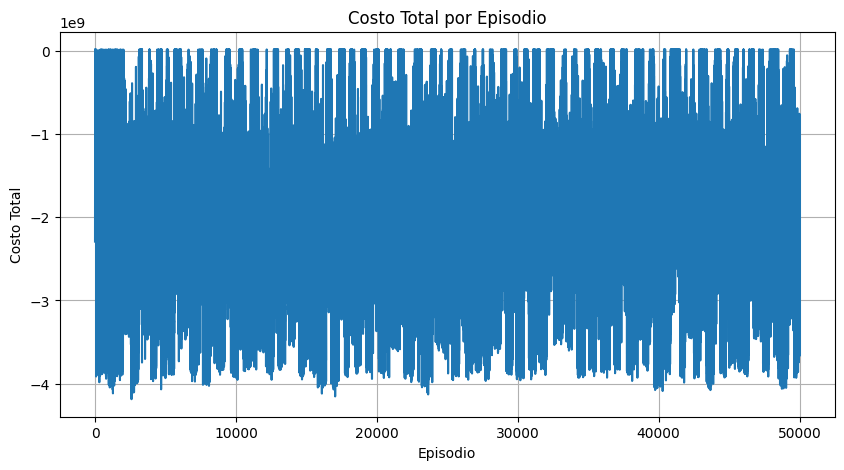

Instalaciones por ubicación:
Ubicación 1: 0 tiendas
Ubicación 2: 0 tiendas
Ubicación 3: 0 tiendas
Ubicación 4: 0 tiendas
Ubicación 5: 0 tiendas
Ubicación 6: 0 tiendas
Ubicación 7: 0 tiendas
Ubicación 8: 0 tiendas
Ubicación 9: 0 tiendas
Ubicación 10: 0 tiendas
Ubicación 11: 0 tiendas
Ubicación 12: 0 tiendas
Ubicación 13: 0 tiendas
Ubicación 14: 0 tiendas
Ubicación 15: 0 tiendas


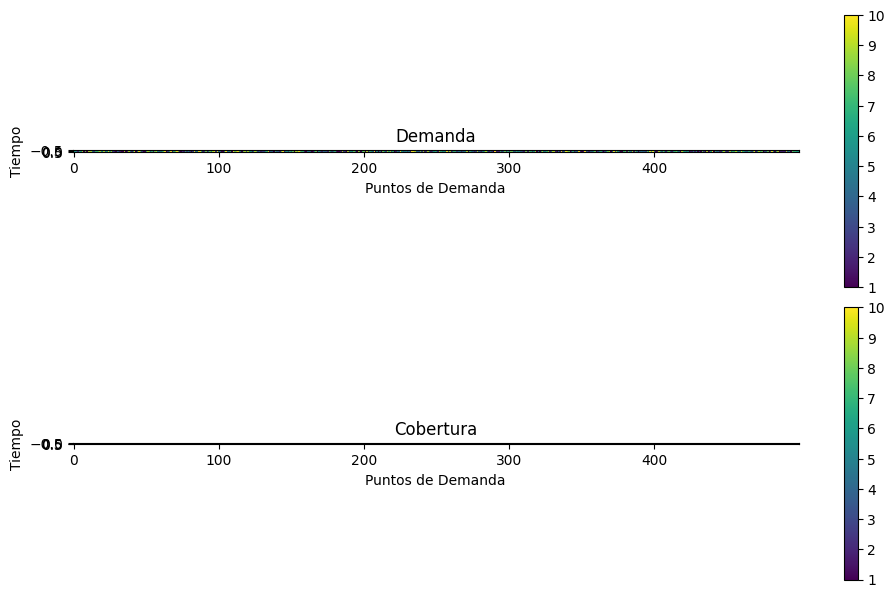

In [55]:
import gym
from gym import spaces
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.animation as animation

class HumanitarianFacilityLocationEnv(gym.Env):
    """Un entorno para modelar la ubicación de facilidades en situaciones humanitarias."""

    def __init__(self, num_demand_points, num_facilities, num_days, coverage_matrix, demand_matrix, max_installations_per_facility=5, max_capacity_per_facility=500, max_total_installations=20):
        super(HumanitarianFacilityLocationEnv, self).__init__()
        self.num_demand_points = num_demand_points
        self.num_facilities = num_facilities
        self.num_days = num_days
        self.current_day = 0
        self.coverage_matrix = np.array(coverage_matrix, dtype=np.int32)
        self.demand_matrix = np.array(demand_matrix, dtype=np.int32)
        self.max_installations_per_facility = max_installations_per_facility
        self.max_capacity_per_facility = max_capacity_per_facility
        self.max_total_installations = num_facilities
        self.installations_per_facility = np.zeros(num_facilities, dtype=int)
        self.available_installations = num_facilities  # Recursos disponibles
        self.action_space = spaces.MultiDiscrete([num_facilities, 2])  # Acciones: índice de la facilidad y acción (instalar o mover)
        self.observation_space = spaces.Box(low=0, high=max_capacity_per_facility * max_installations_per_facility, shape=(num_demand_points,), dtype=np.int32)
        self.state = self.update_coverage()

    def reset(self):
        self.current_day = 0
        self.installations_per_facility.fill(0)
        self.available_installations = self.max_total_installations  # Reiniciar recursos disponibles
        self.state = self.update_coverage()
        return self.state

    def update_coverage(self):
        coverage_effective = np.zeros(self.num_demand_points)
        for fac in range(self.num_facilities):
            installation_effect = self.installations_per_facility[fac] * self.max_capacity_per_facility
            coverage_effective += self.coverage_matrix[fac] * installation_effect
        self.state = np.maximum(self.demand_matrix - coverage_effective, 0)
        return self.state

    def step(self, action):
        facility_index, action_type = action
        
        if action_type == 0:  # Instalar tienda
            if self.available_installations > 0 and self.installations_per_facility[facility_index] < self.max_installations_per_facility:
                self.installations_per_facility[facility_index] += 1
                self.available_installations -= 1
                #print(f"Instalada una tienda en la ubicación {facility_index}. Total instalaciones: {self.installations_per_facility[facility_index]}")
            #else:
                #print(f"No se pudo instalar en la ubicación {facility_index}. Condiciones no cumplidas.")


        elif action_type == 1:  # Mover tienda
            # Elegir una ubicación de destino
            destination_index = random.choice(range(self.num_facilities)) 
            # Asegúrate de que la ubicación de destino tenga espacio
            if self.installations_per_facility[destination_index] < self.max_installations_per_facility:
                # Mover la tienda
                self.installations_per_facility[facility_index] -= 1
                self.installations_per_facility[destination_index] += 1

        self.current_day += 1
        self.state = self.update_coverage()
        total_cost = self._calculate_total_cost()
        reward = -total_cost
        done = self.current_day >= self.num_days
        info = {"total_cost": total_cost}
        return self.state, reward, done, info

    def _calculate_total_cost(self):
        # Penalización por demanda no atendida (aumentada)
        unmet_demand_penalty = 5000 * np.sum(self.demand_matrix - self.state)
        # Costo de instalación (agregado)
        installation_cost = 500 * np.sum(self.installations_per_facility > 0)
        return unmet_demand_penalty + installation_cost

# Implementación de Q-Learning
class QLearningAgent:
    def __init__(self, env, alpha=0.1, gamma=0.9, epsilon=0.1, num_intervals=10):
        self.env = env
        self.alpha = alpha  # Tasa de aprendizaje
        self.gamma = gamma  # Factor de descuento
        self.epsilon = epsilon  # Probabilidad de exploración
        self.num_intervals = num_intervals
        self.observation_intervals = np.linspace(0, env.observation_space.high[0], num_intervals)

        # Crea la tabla Q con las dimensiones correctas para el espacio de acción MultiDiscrete
        self.q_table = np.zeros((num_intervals, env.action_space.nvec[0], env.action_space.nvec[1]))

    def get_state_index(self, state):
        # Encuentra el índice del intervalo al que pertenece el estado
        state_index = np.clip(state[0], self.observation_intervals[0], self.observation_intervals[-1])
        interval_index = np.searchsorted(self.observation_intervals, state_index)
        return interval_index

    def choose_action(self, state):
        state_index = self.get_state_index(state)  # Obtén el índice del estado discreto
        if np.random.rand() < self.epsilon:
            # Exploración: elegir una acción aleatoria
            return self.env.action_space.sample()
            print(f"Acción aleatoria elegida: {action}")
        else:
            # Explotación: elegir la acción con el valor Q más alto
            # Encuentra la acción con el valor Q más alto dentro del estado discreto
            best_action = np.unravel_index(np.argmax(self.q_table[state_index]), self.q_table[state_index].shape)
            return best_action

    def update_q_table(self, state, action, reward, next_state, done):
        state_index = self.get_state_index(state)
        next_state_index = self.get_state_index(next_state)
        # Actualiza la tabla Q usando la ecuación de Q-Learning
        self.q_table[state_index, action[0], action[1]] += self.alpha * (reward + self.gamma * np.max(self.q_table[next_state_index]) - self.q_table[state_index, action[0], action[1]])

    def _calculate_total_cost(self):
        # Penalización por demanda no atendida, ahora más severa
        unmet_demand_penalty = 10000 * np.sum(np.maximum(self.demand_matrix - self.state, 0))

        # Costo de instalación, con un costo adicional por número de tiendas
        installation_cost = 1000 * np.sum(self.installations_per_facility)

        # Recompensa por demanda cubierta (incentivo)
        coverage_reward = 500 * np.sum(np.minimum(self.state, self.demand_matrix))

        # Costo total es la penalización menos los incentivos
        total_cost = unmet_demand_penalty + installation_cost - coverage_reward

        return total_cost



# Entrenar al agente
env = HumanitarianFacilityLocationEnv(demp, fac, num_days, m_cover, m_demp, max_installations_per_facility)
agent = QLearningAgent(env)


num_episodes = 50000

cost_history = []

epsilon_start = 1.0
epsilon_end = 0.1
epsilon_decay = 0.995
epsilon = epsilon_start  # Establece el epsilon inicial fuera del bucle de episodios

for episode in range(num_episodes):
    state = env.reset()
    done = False
    total_episode_cost = 0  # Asegúrate de que esta es la variable correctamente nombrada
    while not done:
        if np.random.rand() < epsilon:  # Decisión entre exploración y explotación
            action = env.action_space.sample()
        else:
            action = agent.choose_action(state)  # Esta función ya debería elegir la mejor acción basada en Q-table
        
        next_state, reward, done, info = env.step(action)
        agent.update_q_table(state, action, reward, next_state, done)
        state = next_state
        
        next_state, reward, done, info = env.step(action)

        
        # Decaimiento de epsilon después de cada episodio
        epsilon = max(epsilon_end, epsilon_decay * epsilon)
        total_episode_cost += info['total_cost']  # Aquí también asegúrate de que el nombre es correcto

    cost_history.append(total_episode_cost)
    if (episode+1)%1000==0:
        print(f"Episodio {episode+1} - Costo Total: {total_episode_cost}")
        print(f"Episodio {episode+1} - Recompensa: {reward}")
        print(f"Acción elegida: {action}")  # Muestra qué acción se ha elegido
        #print(f"Estado después de la acción: {next_state}")  # Muestra el estado después de la acción

# Visualización del costo total a lo largo de los episodios
plt.figure(figsize=(10, 5))
plt.plot(cost_history)
plt.title("Costo Total por Episodio")
plt.xlabel("Episodio")
plt.ylabel("Costo Total")
plt.grid(True)
plt.show()


# Visualización
def visualize_env(env):
    fig, axs = plt.subplots(2, 1, figsize=(10, 6))

    # Asumiendo que 'demand_matrix' y 'state' pueden ser manipulados para ser 2D si no lo son.
    demand_shape = (1, -1) if env.demand_matrix.ndim == 1 else env.demand_matrix.shape
    state_shape = (1, -1) if env.state.ndim == 1 else env.state.shape

    # Mapa de calor para la demanda
    im_demand = axs[0].imshow(env.demand_matrix.reshape(demand_shape), cmap='viridis', interpolation='nearest')
    fig.colorbar(im_demand, ax=axs[0], orientation='vertical')
    axs[0].set_title("Demanda")
    axs[0].set_xlabel("Puntos de Demanda")
    axs[0].set_ylabel("Tiempo")

    # Mapa de calor para la cobertura
    im_coverage = axs[1].imshow(env.state.reshape(state_shape), cmap='viridis', interpolation='nearest')
    fig.colorbar(im_coverage, ax=axs[1], orientation='vertical')
    axs[1].set_title("Cobertura")
    axs[1].set_xlabel("Puntos de Demanda")
    axs[1].set_ylabel("Tiempo")

    # Mostrar información de las instalaciones
    print("Instalaciones por ubicación:")
    for i, num_installations in enumerate(env.installations_per_facility):
        print(f"Ubicación {i+1}: {num_installations} tiendas")
    plt.tight_layout()
    plt.show()

# Ejecutar la visualización
env = HumanitarianFacilityLocationEnv(demp, fac, num_days, m_cover, m_demp, max_installations_per_facility)
visualize_env(env)